# Explainable graph network for Graph Convolutional Networks for affordable epilepsy detection with EEG with affordable devices in Africa

In [1]:
! pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [2]:
!pip install mne -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 34.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
import os
import mne
import json
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from torch.nn import Module, Linear , LayerNorm, BatchNorm1d, Dropout
#from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
import torch.nn.functional as F
import torch
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import networkx as nx
from collections import Counter

mne.set_log_level("ERROR")

### About Data

Electroencephalography (EEG) data collected in people with epilepsy (N=163) and healthy controls (N=138) in two difficult-to-reach areas in rural Guinea-Bissau and Nigeria. Five minutes of fourteen channel resting-state EEG data were acquired with a portable, low-cost consumer-grade EEG recording headset. Experiments started either with two minutes of eyes closed or two minutes of eyes open which was randomized across participants. The order of the experiment is clarified in the meta-data files.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/DATASET

/content/drive/MyDrive/DATASET


In [6]:
gb_df = pd.read_csv("metadata_guineabissau.csv")

In [8]:
gb_df.head(5)

,subject.id,Group,Eyes.condition,Remarks,recordedPeriod,startTime
0,1,Epilepsy,closed-3min-then-open-2min,by 45s reposition electrodes,301,27/5/2020 14:33
1,2,Control,open-3min-then-closed-2min,NaN,309,26/5/2020 22:44
2,3,Epilepsy,closed-3min-then-open-2min,NaN,309,27/5/2020 14:26
3,4,Epilepsy,closed-3min-then-open-2min,"Green lights not shown, but good EEG traces",299,27/5/2020 15:23
4,5,Control,closed-3min-then-open-2min,NaN,302,23/5/2020 19:09


In [7]:
ni_df = pd.read_csv("metadata_nigeria.csv")

In [ ]:
ni_df.head(5)

## Datasets transformations

In [8]:
def file_exists(file_path):
    return os.path.isfile(file_path)

### Nigeria

Adding new columns

In [9]:
ni_df["Eyes.condition"] = ni_df["first_condition"].apply(lambda x: "open-3min-then-closed-2min" if x == "open" else "closed-3min-then-open-2min")
# ni_df["csv.file"] = ni_df["csv.file"].apply(lambda x: "EEGs_Nigeria/"+x)
ni_df["csv.file"] = ni_df["csv.file"].apply(lambda x: "EEGs_Nigeria/"+x)
ni_df["Group"] = ni_df["Group"].apply(lambda x: x.title())
ni_df["subject.id"] = ni_df["subject.id"].apply(lambda x: "NI-" + str(x))
ni_df["Country"] = "Nigeria"
ni_df['file_exists'] = ni_df['csv.file'].apply(lambda x: file_exists(x))
ni_df = ni_df.drop(columns=['session.id'])

In [10]:
def count_rows(file):
  data = pd.read_csv(file, compression='gzip',
                   on_bad_lines='skip')
  return len(data)

In [ ]:
ni_df.head(5)

In [11]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=ni_df)

https://docs.google.com/spreadsheets/d/1zjprOANMuVy6g_HYm4Tp-UU4VQCGZasmkqWQGCSiIqY/edit#gid=0


Some data cleaning will be required

In [ ]:
ni_df[ni_df["recordedPeriod"]<200]

In [ ]:
(ni_df[ni_df["recordedPeriod"]<200])["remarks"].unique()

Removing data where dataset are not found in the files. Removing as well data for subject 124 as sample is split in two and difficult to generalize with the rest of data. Removing data that is marked for removal in the remarks - either mistake was made during a recording, recording was too short or poor quality.

In [12]:
samples_to_remove = ["NI-124", "NI-536", "NI-522", "NI-508", "NI-515", "NI-580"]

In [13]:
ni_df = ni_df[(ni_df['file_exists']) & (~ni_df['subject.id'].isin(samples_to_remove))]
ni_df = ni_df[(ni_df['file_exists']) & (~ni_df['subject.id'].isin(samples_to_remove))]

# Check the result
print(ni_df)

    subject.id  recordedPeriod        startTime first_condition  \
0         NI-6             270  26/9/2016 13:13            open   
1         NI-9             271  26/9/2016 13:30          closed   
2        NI-10             272  26/9/2016 13:36            open   
3        NI-11             274  26/9/2016 13:42          closed   
4        NI-12             271  26/9/2016 13:47            open   
..         ...             ...              ...             ...   
216     NI-634             268  1/10/2016 16:25          closed   
217     NI-635             268  1/10/2016 16:31            open   
218     NI-636             268  1/10/2016 16:36          closed   
219     NI-637             268  1/10/2016 16:43            open   
220     NI-638             273  1/10/2016 16:49          closed   

                                               remarks     Group  \
0                                                  NaN   Control   
1                                                  NaN   Co

In [14]:
ni_df["file_rows_count"] = ni_df["csv.file"].apply(lambda x: count_rows(x))

In [ ]:
ni_df.head(5)

### Guinea-Bissau

Adding new columns

In [ ]:
gb_df["first_condition"] = gb_df['Eyes.condition'].str.split('-').str[0]
gb_df["csv.file"] = gb_df["subject.id"].apply(lambda x: "EEGs_Guinea-Bissau/signal-" + str(x) + ".csv.gz")
gb_df["Group"] = gb_df["Group"].apply(lambda x: x.title())
gb_df["subject.id"] = gb_df["subject.id"].apply(lambda x: "GB-" + str(x))
gb_df["Country"] = "Guinea Bissau"
gb_df['file_exists'] = gb_df['csv.file'].apply(lambda x: file_exists(x))

In [ ]:
gb_df = gb_df[(gb_df['file_exists'])]

In [ ]:
gb_df["file_rows_count"] = gb_df["csv.file"].apply(lambda x: count_rows(x))

In [ ]:
gb_df.head(5)

## Display data

In [ ]:
def plot_frequency_all(path):

    data = pd.read_csv(path, compression='gzip',
                       on_bad_lines='skip')

    # Get the x-axis (first column) and the y-values (all other columns)
    x = data.iloc[:, 0]
    columns = data.columns[1:15]  # Skip the first column for the y-values

    # Create subplots
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(12, 20), sharex=True)

    for i, col in enumerate(columns):
        axes[i].plot(x, data[col], label=col)
        axes[i].set_title(col)
        axes[i].set_ylabel("Value")
        axes[i].grid(True)
        axes[i].legend()

    # Set common x-label
    plt.xlabel("Index")
    # plt.tight_layout()
    plt.show()

In [ ]:
def plot_frequency_closed(path, ni_df):
    """
    Plot the frequency data from the specified .gz file, displaying only a subset
    of rows based on the `first_condition` and `row_count` from the ni_df dataframe.
    Purpose is cutting data to only the data that represent closed eyes state.

    Parameters:
        path (str): Path to the .gz file.
        ni_df (pd.DataFrame): DataFrame containing metadata about the files, including
                              `row_count` and `first_condition`.
    """
    # Lookup row_count and first_condition in ni_df
    row_info = ni_df[ni_df['csv.file'] == path]

    if row_info.empty:
        raise ValueError(f"No matching entry found for file path: {path}")

    row_count = row_info['file_rows_count'].values[0]
    first_condition = row_info['first_condition'].values[0]

    # Calculate the number of rows to read (0.4 of the total rows)
    rows_to_read = int(row_count * 0.4)

    # Load the relevant portion of data
    with gzip.open(path, 'rt') as f:
        if first_condition == "closed":
            # Read the first 0.4 of rows, including the header
            data = pd.read_csv(f, nrows=rows_to_read + 1)  # +1 to include the header
        elif first_condition == "open":
            # Calculate how many rows to skip but include the header
            skip_rows = row_count - rows_to_read
            data = pd.read_csv(f, skiprows=range(1, skip_rows + 1))  # Skip initial rows but not the header
        else:
            raise ValueError(f"Invalid first_condition: {first_condition}. Must be 'open' or 'closed'.")

    # Get the x-axis (first column) and the y-values (all other columns)
    x = data.iloc[:, 0]
    columns = data.columns[1:15]  # Use the first 14 columns after the x-axis for plotting

    # Create subplots
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(12, 20), sharex=True)

    for i, col in enumerate(columns):
        axes[i].plot(x, data[col], label=col)
        axes[i].set_title(col)
        axes[i].set_ylabel("Value")
        axes[i].grid(True)
        axes[i].legend()

    # Set common x-label
    plt.xlabel("Index")
    plt.tight_layout()
    plt.show()


Let's see some example data from samples

In [15]:
data = pd.read_csv('EEGs_Nigeria/signal-10-1.csv.gz',    on_bad_lines='skip')

In [ ]:
data

In [ ]:
data.info()

Let's take a look at the plots for some sample signal.

In [ ]:
plot_frequency_all("EEGs_Nigeria/signal-10-1.csv.gz")

Display frequencies plot only for the closed eyes state.

In [ ]:
plot_frequency_closed("EEGs_Nigeria/signal-10-1.csv.gz", ni_df)

Same for Guinea-Bissau data.

In [16]:
data = pd.read_csv('EEGs_Guinea-Bissau/signal-1.csv.gz', compression='gzip',
                   on_bad_lines='skip')

In [ ]:
data

In [ ]:
data.info()

In [ ]:
plot_frequency_all("EEGs_Guinea-Bissau/signal-10.csv.gz")

In [ ]:
plot_frequency_closed("EEGs_Guinea-Bissau/signal-10.csv.gz", gb_df)

## Building Pipeline and model

### Load and process EEG data

In this step, we define a function to load EEG data stored in .gz files.

In [17]:
def load_eeg_from_gz(file_path, row_count, first_condition):
    """
    Load a specific portion of the data from a .gz file based on the condition.
    Required to cut dataset only to the closed eyes data.
    Parameters:
        file_path (str): Path to the .gz file.
        row_count (int): Total number of rows in the file.
        first_condition (str): Condition to decide which portion of data to load ("open" or "closed").

    Returns:
        pd.DataFrame: Subset of the EEG data.
    """
    perc =0.5
    # Calculate the number of rows to read (0.4 of the total rows)
    rows_to_read = int(row_count * perc)

    with gzip.open(file_path, 'rt') as f:
      if first_condition == "closed":
            # Read the first 0.perc of rows
            eeg_data = pd.read_csv(f, nrows=rows_to_read)
      elif first_condition == "open":
            # Skip rows to get the last perc.4 of rows
            skip_rows = row_count - rows_to_read
            eeg_data = pd.read_csv(f, skiprows=range(1, skip_rows + 1))  # Skip the header and initial rows
      else:
            raise ValueError(f"Invalid first_condition: {first_condition}. Must be 'open' or 'closed'.")

    return eeg_data

Next, we preprocess the raw EEG data. This involves:

1. Selecting Relevant Columns: Extracting columns that represent EEG channels.
2. Creating an `MNE RawArray` Object: Converting the DataFrame into an MNE object to take advantage of its built-in signal processing functions.
3. Applying Bandpass Filtering: Filtering the signal to focus on relevant frequencies (1–30 Hz) and remove noise.

In [18]:
# @title Default title text
def preprocess_eeg(raw_data, low_freq=1, high_freq=30, sfreq=128):
    # Extract columns 1–14 (EEG data)
    eeg_data = raw_data.iloc[:, 0:14]
    ch_names = eeg_data.columns.tolist()  # Channel names (columns 1–14)
    ch_types = ["eeg"] * len(ch_names)  # All channels as EEG

    # Create MNE RawArray object
    raw_array = mne.io.RawArray(
        eeg_data.values.T,
        mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    )
    raw_array .set_eeg_reference()

    # Bandpass filtering (1–30 Hz)
    raw_array.filter(low_freq, high_freq, fir_design='firwin')

   #epochs=mne.make_fixed_length_epochs(data,duration=5,overlap=1)
   # epochs=epochs.drop_bad()


    #raw_array = normalize_amplitude(raw_array)
    return raw_array


def preprocess_eeg_with_epochs(raw_data, duration=5, overlap=1, sfreq=128):
    """
    Preprocess EEG data with epoching and filtering.

    Parameters:
    -----------
    raw_data : pd.DataFrame
        Raw EEG data
    duration : float
        Duration of each epoch in seconds
    overlap : float
        Overlap between epochs in seconds
    sfreq : float
        Sampling frequency

    Returns:
    --------
    epochs : mne.Epochs
        Preprocessed and epoched data
    n_epochs : int
        Number of valid epochs after dropping bad ones
    """
    # Extract EEG data (columns 1-14)
    eeg_data = raw_data.iloc[:, 1:15]    #it should be 1:15

    ch_names = eeg_data.columns.tolist()
    ch_types = ["eeg"] * len(ch_names)

    # Create MNE RawArray
    raw_array = mne.io.RawArray(
        eeg_data.values.T,
        mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    )

    # Bandpass filtering (1-30 Hz)
    raw_array.filter(1, 45, fir_design='firwin')

    #ICA motion correction
    ica = mne.preprocessing.ICA(n_components=10, random_state=97, max_iter='auto')
    ica.fit(raw_array)

    # Then exclude bad components (example: components [0, 1] are bad)
    ica.exclude = [0, 1]  # Replace with real bad components after inspecting
    raw_array = ica.apply(raw_array)




    # Create epochs
    epochs = mne.make_fixed_length_epochs(raw_array, duration=duration, overlap=overlap)

    # Drop bad epochs
    epochs = epochs.drop_bad()

    return epochs, len(epochs)

In [19]:
def expand_labels_for_epochs(original_labels, n_epochs_per_sample):
    """
    Expand labels to match the number of epochs for each sample.

    Parameters:
    -----------
    original_labels : list or np.array
        Original labels for each sample
    n_epochs_per_sample : list
        Number of valid epochs for each sample

    Returns:
    --------
    expanded_labels : np.array
        Labels expanded to match the number of epochs
    """
    expanded_labels = []
    for label, n_epochs in zip(original_labels, n_epochs_per_sample):
        expanded_labels.extend([label] * n_epochs)
    return np.array(expanded_labels)

In [ ]:
def normalize_amplitude(raw_data, technique='min_max', axis=None, keepdims=True):
    """
    Normalize data using various techniques with flexible axis handling.

    Parameters:
    -----------
    raw_data : MNE Raw object or numpy array
        Input data to be normalized
    technique : str
        Normalization technique to use:
        - 'min_max': scales data to [0, 1] range
        - 'min_max_symmetric': scales data to [-1, 1] range
        - 'mean_std': standardizes data by removing mean and scaling to unit variance
        - 'mean_only': only subtracts mean (centered data)
    axis : int or None
        Axis along which to compute statistics. If None, compute globally.
        axis=1 for per-channel normalization
    keepdims : bool
        Whether to keep dimensions when computing statistics

    Returns:
    --------
    raw_data : MNE Raw object or numpy array
        Normalized data in the same format as input
    """
    # Get the data array
    if hasattr(raw_data, 'get_data'):
        raw_data_values = raw_data.get_data()
    else:
        raw_data_values = raw_data.copy()

    # Compute statistics along specified axis
    min_val = raw_data_values.min(axis=axis, keepdims=keepdims)
    max_val = raw_data_values.max(axis=axis, keepdims=keepdims)
    mean_val = raw_data_values.mean(axis=axis, keepdims=keepdims)
    std_val = raw_data_values.std(axis=axis, keepdims=keepdims)

    # Handle division by zero cases
    eps = 1e-8

    # Apply normalization based on selected technique
    if technique == 'min_max':
        denominator = (max_val - min_val)
        denominator = np.where(denominator == 0, eps, denominator)
        normalized_data = (raw_data_values - min_val) / denominator

    elif technique == 'min_max_symmetric':
        denominator = (max_val - min_val)
        denominator = np.where(denominator == 0, eps, denominator)
        normalized_data = 2 * ((raw_data_values - min_val) / denominator) - 1

    elif technique == 'mean_std':
        denominator = std_val
        denominator = np.where(denominator == 0, eps, denominator)
        normalized_data = (raw_data_values - mean_val) / denominator

    elif technique == 'mean_only':
        normalized_data = raw_data_values - mean_val

    else:
        raise ValueError(f"Unknown normalization technique: {technique}")

    # Return data in the same format as input
    if hasattr(raw_data, 'get_data'):
        raw_data._data = normalized_data
        return raw_data
    else:
        return normalized_data

The next step is to calculate the **Phase-Locking Value (PLV)** matrix, which measures the functional connectivity between EEG channels. The PLV quantifies how consistent the phase difference between two signals is over time. This is useful for identifying synchronized brain activity between regions.

1. `calculate_plv_matrix` Function:

Computes a pairwise PLV matrix for all EEG channels.
Each entry in the matrix represents the PLV value between two channels.

2. `calculate_plv` Function:

Calculates the PLV between two individual EEG signals by comparing their phase differences.

In [20]:
def calculate_plv_matrix(eeg_data):
    n_channels = len(eeg_data.info['ch_names'])
    plv_matrix = np.zeros((n_channels, n_channels))
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            signal1 = eeg_data.get_data(picks=i).flatten()
            signal2 = eeg_data.get_data(picks=j).flatten()
            plv_matrix[i, j] = calculate_plv(signal1, signal2)
    return plv_matrix

def calculate_plv(signal1, signal2):
    phase1 = np.angle(signal1)
    phase2 = np.angle(signal2)
    return np.abs(np.mean(np.exp(1j * (phase1 - phase2))))

**Feature Computation for EEG Channels**

To provide more detailed information about each EEG channel, we compute specific features:

1. *Katz Fractal Dimension (Katz FD):*

A measure of signal complexity, often used in EEG analysis to quantify how irregular the signal is.

2. *Band Energy:*

The energy of the EEG signal in specific frequency bands:
* Delta (1–4 Hz): Associated with deep sleep and unconscious states.
* Theta (4–8 Hz): Linked to relaxation and meditative states.
* Alpha (8–13 Hz): Represents calm and focused mental states.
* Beta (13–30 Hz): Associated with active thinking and problem-solving.

The function calculates these features for each EEG channel and returns them as a dictionary.

In [21]:
def compute_features(eeg_data):
    """
    Compute features (Katz FD, band energy) for each EEG channel.
    :param eeg_data: MNE RawArray object with EEG channels.
    :return: Dictionary with features for each channel.
    """
    features = {}
    sfreq = eeg_data.info['sfreq']

    for ch_name in eeg_data.info['ch_names']:
        signal = eeg_data.get_data(picks=ch_name).flatten()

        # Katz FD
        L = np.sum(np.sqrt(np.diff(signal)**2 + 1))
        d = np.max(signal) - np.min(signal)
        katz_fd = np.log10(L) / np.log10(d)

        # Band energy (delta, theta, alpha, beta)
        freqs, psd = mne.time_frequency.psd_array_welch(signal, sfreq=sfreq, n_fft=256)
        delta_energy = np.sum(psd[(freqs >= 1) & (freqs < 4)])
        theta_energy = np.sum(psd[(freqs >= 4) & (freqs < 8)])
        alpha_energy = np.sum(psd[(freqs >= 8) & (freqs < 13)])
        beta_energy = np.sum(psd[(freqs >= 13) & (freqs < 30)])

        features[ch_name] = [katz_fd, delta_energy, theta_energy, alpha_energy, beta_energy]

    return features

This step converts the **Phase-Locking Value (PLV)** matrix into a graph where:

* **Nodes** represent EEG channels (e.g., T3, T4).
* **Edges connect** channels based on their PLV values, indicating functional connectivity.

In [22]:
def create_graph_from_plv(plv_matrix, channel_names):
    """
    Create a graph from a PLV matrix using original channel names as node labels.
    """
    G = nx.Graph()

    # Add nodes with channel names as labels
    for i, name in enumerate(channel_names):
        G.add_node(name)  # Use the original channel name instead of numeric ID

    # Add edges with weights
    for i in range(len(plv_matrix)):
        for j in range(i + 1, len(plv_matrix)):
            if plv_matrix[i, j] > 0:  # Include edges with positive weights
                G.add_edge(channel_names[i], channel_names[j], weight=plv_matrix[i, j])

    return G

This step automates the pipeline for multiple EEG recordings. For each file:

1. **Load the EEG Data:** Read the .gz file containing the raw EEG data.
2. **Preprocess the Signal:** Apply bandpass filtering to isolate relevant frequencies.
3. **Calculate the PLV Matrix:** Compute pairwise functional connectivity between channels.
4. **Create and Save the Graph:** Convert the PLV matrix into a graph and save it as a .gml file.
5. **Compute and Save Node Features:** Extract features like Katz FD and band energy for each channel and save them in a JSON file.

In [23]:
def process_all_files(metadata, output_dir, feature_output_dir):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(feature_output_dir, exist_ok=True)

    for _, row in metadata.iterrows():
        # Load EEG data from .gz file
        eeg_data = load_eeg_from_gz(row['csv.file'], row['file_rows_count'], row['first_condition'])

        # Filtering and processing the signal
        raw_array = preprocess_eeg(eeg_data.iloc[:, 1:15])

        # Calculate PLV
        plv_matrix = calculate_plv_matrix(raw_array)

        # Create the graph
        graph = create_graph_from_plv(plv_matrix, raw_array.info['ch_names'])

        # Save the graph
        # Convert edge weights to float (if they're np.float64)
        for u, v, data in graph.edges(data=True):
           if 'weight' in data:
             data['weight'] = float(data['weight'])
        nx.write_gml(graph, os.path.join(output_dir, f"{row['subject.id']}_graph.gml"))

        # Compute features and save separately
        features = compute_features(raw_array)
        feature_file = os.path.join(feature_output_dir, f"{row['subject.id']}_features.json")
        with open(feature_file, 'w') as f:
            json.dump(features, f)


def process_all_files_with_epochs(metadata, output_dir, feature_output_dir, duration=5, overlap=1):
    """
    Process all EEG files with epoching and save results.

    Parameters:
    -----------
    metadata : pd.DataFrame
        Metadata containing file information
    output_dir : str
        Directory to save graph files
    feature_output_dir : str
        Directory to save feature files
    duration : float
        Duration of each epoch in seconds
    overlap : float
        Overlap between epochs in seconds

    Returns:
    --------
    n_epochs_per_sample : list
        Number of valid epochs for each sample
    """
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(feature_output_dir, exist_ok=True)

    n_epochs_per_sample = []

    for idx, row in metadata.iterrows():
        # Load EEG data
        eeg_data = load_eeg_from_gz(row['csv.file'], row['file_rows_count'], row['first_condition'])

        # Preprocess and create epochs
        epochs, n_epochs = preprocess_eeg_with_epochs(eeg_data, duration=duration, overlap=overlap)
        n_epochs_per_sample.append(n_epochs)

        # Process each epoch
        for epoch_idx in range(n_epochs):
            epoch_data = epochs[epoch_idx]

            # Calculate PLV for this epoch
            plv_matrix = calculate_plv_matrix(epoch_data)

            # Create graph for this epoch
            graph = create_graph_from_plv(plv_matrix, epoch_data.info['ch_names'])

            # Save graph with epoch index in filename
            # Convert edge weights to float (if they're np.float64)
            for u, v, data in graph.edges(data=True):
              if 'weight' in data:
                data['weight'] = float(data['weight'])

            nx.write_gml(graph, os.path.join(output_dir, f"{row['subject.id']}_epoch{epoch_idx}_graph.gml"))

            # Compute and save features for this epoch
            features = compute_features(epoch_data)
            feature_file = os.path.join(feature_output_dir, f"{row['subject.id']}_epoch{epoch_idx}_features.json")
            with open(feature_file, 'w') as f:
                json.dump(features, f)

    return n_epochs_per_sample

### Build GAT model

This step combines the graphs saved in `.gml` files with the node features saved in `.json` files. Each graph is converted to a PyTorch Geometric `Data` object, which includes:

* Node Features: Features like Katz FD and band energy.
* Edge Index and Attributes: Connectivity and weights from the PLV matrix.
* Labels: Encoded class labels (Control or Epilepsy).

In [24]:
def load_graphs_and_labels_with_features(gml_dir, feature_dir, metadata):
    """
    Load .gml graphs, enrich with features, and convert to PyTorch Geometric format.
    """
    graphs = []
    labels = []

    label_encoder = LabelEncoder()
    metadata['encoded_group'] = label_encoder.fit_transform(metadata['Group'])

    for _, row in metadata.iterrows():
        gml_file = os.path.join(gml_dir, f"{row['subject.id']}_graph.gml")
        feature_file = os.path.join(feature_dir, f"{row['subject.id']}_features.json")

        if os.path.exists(gml_file) and os.path.exists(feature_file):
            # Load graph
            graph = nx.read_gml(gml_file)

            # Load features
            with open(feature_file, 'r') as f:
                features = json.load(f)

            # Map node labels to numeric indices
            node_mapping = {node: idx for idx, node in enumerate(graph.nodes)}

            # Convert edges to numeric indices
            edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in graph.edges], dtype=torch.long).t().contiguous()

            # Convert node features to tensor
            node_features = torch.tensor([features[node] for node in graph.nodes], dtype=torch.float32)

            # Get edge attributes (e.g., weights)
            edge_attr = torch.tensor([data['weight'] for _, _, data in graph.edges(data=True)], dtype=torch.float32)

            # Create PyTorch Geometric data object
            data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, num_nodes=len(graph.nodes), y=torch.tensor([row['encoded_group']]))

            graphs.append(data)
            labels.append(row['encoded_group'])

    # Convert labels to tensor
    labels = torch.tensor(labels, dtype=torch.long)
    return graphs, labels

def load_graphs_and_labels_with_epochs(gml_dir, feature_dir, metadata, n_epochs_per_sample):
    """
    Load epoched graphs and expand labels accordingly.
    """
    graphs = []

    # Encode labels first
    label_encoder = LabelEncoder()
    metadata['encoded_group'] = label_encoder.fit_transform(metadata['Group'])

    # Get original labels and expand them based on epochs
    original_labels = metadata['encoded_group'].values
    expanded_labels = expand_labels_for_epochs(original_labels, n_epochs_per_sample)

    # Load each epoch's graph
    current_epoch_idx = 0
#    for idx, row in metadata.iterrows():
#        n_epochs = n_epochs_per_sample[idx]

    for i, (_, row) in enumerate(metadata.iterrows()):
        n_epochs = n_epochs_per_sample[i]

        for epoch_idx in range(n_epochs):
            gml_file = os.path.join(gml_dir, f"{row['subject.id']}_epoch{epoch_idx}_graph.gml")
            feature_file = os.path.join(feature_dir, f"{row['subject.id']}_epoch{epoch_idx}_features.json")

            if os.path.exists(gml_file) and os.path.exists(feature_file):
                # Load graph
                graph = nx.read_gml(gml_file)

                # Load features
                with open(feature_file, 'r') as f:
                    features = json.load(f)

                # Create PyTorch Geometric data object
                node_mapping = {node: idx for idx, node in enumerate(graph.nodes)}
                edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in graph.edges], dtype=torch.long).t().contiguous()
                node_features = torch.tensor([features[node] for node in graph.nodes], dtype=torch.float32)
                edge_attr = torch.tensor([data['weight'] for _, _, data in graph.edges(data=True)], dtype=torch.float32)

                data = Data(
                    x=node_features,
                    edge_index=edge_index,
                    edge_attr=edge_attr,
                    num_nodes=len(graph.nodes),
                    y=torch.tensor([expanded_labels[current_epoch_idx]])
                )

                graphs.append(data)
                current_epoch_idx += 1

    # Convert expanded labels to tensor
    labels = torch.tensor(expanded_labels, dtype=torch.long)
    return graphs, labels

Defining the GAT Model used for classification:

1. Applying Graph Attention Layers (`GATConv`): These layers compute node embeddings using attention mechanisms that weigh the importance of each node's neighbors.
2. Combining Layers: The first GAT layer outputs intermediate embeddings, and the second outputs class probabilities for each graph.

In [25]:
class GATModel(Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim=0,  heads=1,  dropout=0.3):
        """
        Initialize the GAT model.
        Args:
            in_channels (int): Number of input node features.
            hidden_channels (int): Number of hidden channels in the first GAT layer.
            out_channels (int): Number of output classes.
            heads (int): Number of attention heads in the first GAT layer (default=1).

        super(GATModel, self).__init__()
        #self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)  # First attention layer
        #self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)  # Second layer
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True)  # First attention layer
        self.gat2 = GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False)  # Second layer
        """

        super(GATModel, self).__init__()
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=edge_dim)
        self.norm1 = LayerNorm(hidden_channels * heads)

        self.gat2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=1, concat=False, edge_dim=edge_dim)
        self.norm2 = LayerNorm(hidden_channels)

        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        #self.dropout = Dropout(p=dropout)  # 👈 this was missing

    def forward(self, x, edge_index, edge_attr, batch):
    #def forward(self, x, edge_index, edge_attr):
        """
        Forward pass of the GAT model.
        Args:
            x (torch.Tensor): Node features.
            edge_index (torch.Tensor): Edge indices.
            edge_attr (torch.Tensor): Edge attributes (weights).
        Returns:
            torch.Tensor: Log-softmax probabilities for each class.
        """
        '''
        #x = self.gat1(x, edge_index, edge_attr)  # First GAT layer
        x = self.gat1(x, edge_index )  # First GAT layer

        x = F.elu(x)  # Apply activation
        #x = self.gat2(x, edge_index, edge_attr)  # Second GAT layer
        x = self.gat2(x, edge_index)  # Second GAT layer
        '''
        # First GAT + activation + norm
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.norm1(x)
        #x = self.dropout(x)

        # Second GAT + norm + activation
        x = self.gat2(x, edge_index, edge_attr)
        x = self.norm2(x)
        x = F.elu(x)
        #x = self.dropout(x)

        # Global mean pooling to graph-level representation
        #x = global_mean_pool(x, batch)
        x = global_add_pool(x, batch)

        # MLP: Linear -> Activation -> BN -> Linear
        x = self.lin1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #x = self.dropout(x)

        x = self.lin2(x)
        return F.log_softmax(x, dim=1)  # Output class probabilities
        #return x
        #return torch.sigmoid(x)

**Using Grad-CAM for Node Importance in GAT**

Grad-CAM is used to identify the importance of nodes in the graph by analyzing gradients from a specific layer (gat1). The class GradCamGAT computes node importance based on these gradients.

1. The forward method passes data through the target layer and captures gradients via a hook. The global mean pooling aggregates node-level outputs to graph-level predictions.
2. The backward method computes gradients with respect to the graph output.
3. The get_node_importance method calculates node importance by averaging gradients across features.

In [27]:
class GradCamGAT:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register forward hook on the target layer
        self.target_layer.register_forward_hook(self.save_activation)

    def save_gradient(self, grad):
        # Save gradients during backward pass
        self.gradients = grad

    def save_activation(self, module, input, output):
        # Save activations during forward pass
        self.activations = output

    def forward(self, x, edge_index, edge_attr, batch):
        # Forward pass through the target layer
        node_output = self.target_layer(x, edge_index, edge_attr)
        node_output.register_hook(self.save_gradient)  # Register gradient hook
        graph_output = global_mean_pool(node_output, batch)  # Global pooling
        return graph_output, node_output

    def backward(self, output, class_idx=None):
        # Backward pass to compute gradients for a specific class
        if class_idx is None:
            class_idx = output.argmax(dim=1)  # Use the predicted class if no class is specified
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1  # Create one-hot vector for the target class
        output.backward(gradient=one_hot, retain_graph=True)

    def get_node_importance(self):
        # Compute node importance using gradients and activations
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations have not been computed. Did you call forward and backward?")
        gradients = self.gradients.mean(dim=1, keepdim=True)  # Average gradients over nodes
        activations = self.activations  # Use saved activations
        node_importance = (gradients * activations).sum(dim=1)  # Grad-CAM formula
        return node_importance.detach()



# Nigerian dataset

We will now proceed to use the above pipeline for Nigerian dataset.

### GAT model

In [26]:
# Directory containing .gml files
gml_dir = "output4/graphs_nigeria"
feature_dir = "output4/features_nigeria"

Processing all EEG files, create graphs and feature files.

In [27]:
#process_all_files(ni_df, "output4/graphs_nigeria", "output4/features_nigeria")

n_epochs_per_sample = process_all_files_with_epochs(
    ni_df,
    "output4/graphs_nigeria_epoched",
    "output4/features_nigeria_epoched",
    duration=5,
    overlap=0
)

Loading a sample graph from the generated .gml file and inspect its structure:

* **Nodes:** Represent EEG channels.
* **Edges:** Represent functional connectivity (PLV) between channels.
* **Edge Weights:** Represent the strength of connectivity.

In [ ]:
# Path to a sample .gml file
gml_file = "output4/graphs_nigeria_epoched/NI-638_epoch20_graph.gml"

# Load the graph from the .gml file
graph = nx.read_gml(gml_file)

# Print basic information about the graph
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

# Display a few edges with their weights
print("Sample edges with weights:")
for u, v, weight in graph.edges(data='weight'):
    print(f"({u}, {v}) -> weight: {weight}")

Visualizing the graph to better understand the connectivity:

* Nodes are labeled with their channel names.
* Edge weights are displayed, showing the strength of the connections.

In [ ]:
# Load the graph
graph = nx.read_gml(gml_file)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Automatic layout for nodes
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=700,
    node_color="lightblue",
    font_size=10,
    font_color="black",
)
# Add edge labels showing weights
nx.draw_networkx_edge_labels(
    graph, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in graph.edges(data=True)}
)
plt.title("Visualization of EEG Graph (PLV)")
plt.show()


Edges that connect different nodes (representing parts of brain) hold weights that imply how closely correlated are signals for these parts of brain.

In [28]:
# Load data
#graphs, labels = load_graphs_and_labels_with_features(gml_dir, feature_dir, ni_df)
# Load the epoched data with properly expanded labels
graphs, labels = load_graphs_and_labels_with_epochs(
    "output4/graphs_nigeria_epoched",
    "output4/features_nigeria_epoched",
    ni_df,
    n_epochs_per_sample
)

To ensure that both classes (Control and Epilepsy) are proportionally represented in the train and test datasets, we use a stratified split. This ensures the class balance is maintained in both subsets.

In [29]:
# Stratified split to ensure both classes are represented in train and test sets
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    graphs, labels, test_size=0.2, stratify=labels, random_state=42
)


print("Train class distribution:", Counter(train_labels.numpy()))
print("Test class distribution:", Counter(test_labels.numpy()))


Train class distribution: Counter({np.int64(1): 2499, np.int64(0): 1908})
Test class distribution: Counter({np.int64(1): 625, np.int64(0): 477})


Setting up the DataLoader and Model Initialization

In [30]:
# Create DataLoader
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)

# Initialize model
#model = GATModel(in_channels=5, hidden_channels=8, out_channels=2)  # Binary classification
model = GATModel(in_channels=5, hidden_channels=16, out_channels=2, heads=6)
#optimizer = Adam(model.parameters(), lr=0.01)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

The model is trained for 50 epochs. Here's how it works:

1. Training Mode: The model is set to `train()` mode.
2. Forward Pass:
> - Compute node-level embeddings using the GAT layers.
> - Aggregate node embeddings to graph-level predictions using `global_mean_pool`.
3. Loss Calculation: Compute the negative log-likelihood loss between predicted and true labels.
4. Backward Pass and Optimization: Update model weights using backpropagation and the Adam optimizer.

In [31]:
for epoch in range(300):
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()

        out = model(data.x, data.edge_index, data.edge_attr, data.batch)

        # Forward pass
        #node_output = model(data.x, data.edge_index, data.edge_attr)

        # Aggregate node outputs to graph-level predictions using batch information
        #graph_output = global_mean_pool(node_output, data.batch)

        # Compute loss
        #loss = F.nll_loss(graph_output, data.y)
        #loss = F.nll_loss(out, data.y)
        loss = F.cross_entropy(out, data.y)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss}")

Epoch 1, Loss: 187.41865992546082
Epoch 2, Loss: 181.57717514038086
Epoch 3, Loss: 180.6184875369072
Epoch 4, Loss: 179.17058417201042
Epoch 5, Loss: 178.18876558542252
Epoch 6, Loss: 177.03513932228088
Epoch 7, Loss: 176.59065699577332
Epoch 8, Loss: 175.9703362584114
Epoch 9, Loss: 173.13529780507088
Epoch 10, Loss: 173.2721626162529
Epoch 11, Loss: 173.35892432928085
Epoch 12, Loss: 174.13810521364212
Epoch 13, Loss: 173.94898653030396
Epoch 14, Loss: 171.63072794675827
Epoch 15, Loss: 169.90258753299713
Epoch 16, Loss: 169.1829316318035
Epoch 17, Loss: 169.001834243536
Epoch 18, Loss: 169.54145017266273
Epoch 19, Loss: 168.21198716759682
Epoch 20, Loss: 167.36278399825096
Epoch 21, Loss: 167.32471150159836
Epoch 22, Loss: 167.36064705252647
Epoch 23, Loss: 165.6844358742237
Epoch 24, Loss: 166.44317176938057
Epoch 25, Loss: 165.68602538108826
Epoch 26, Loss: 166.94957980513573
Epoch 27, Loss: 167.15816363692284
Epoch 28, Loss: 166.29526168107986
Epoch 29, Loss: 166.69348648190498
E

In [ ]:
torch.save(model.state_dict(), "gat_model.pth")

For each graph in the test set:
- Forward Pass: Generate node-level embeddings using the trained model.
- Graph-Level Aggregation: Aggregate node-level outputs to a single graph-level prediction using `global_mean_pool`.
- Class Prediction: Use the `argmax` function to get the predicted class for the graph.

In [32]:
# Evaluate model on test set (with graph-level pooling)
model.eval()
all_preds = []
all_labels = []
all_probs = []


for data in test_graphs:

    # Forward pass (note: model already pools and gives graph-level prediction)
    out = model(data.x, data.edge_index, data.edge_attr, data.batch)

    # Get predicted class
    preds = out.argmax(dim=1)

    # Forward pass
    #node_output = model(data.x, data.edge_index, data.edge_attr)

    # Aggregate node outputs to graph-level predictions using batch information
    #graph_prediction = global_mean_pool(node_output, data.batch)

    # Get predicted class
    #preds = graph_prediction.argmax(dim=1)

    # Store predicted probabilities for the positive class (class 1)
    probs = torch.softmax(out, dim=1)[:, 1].detach().numpy()  # Probabilities for class 1

    all_preds.append(preds.item())
    all_labels.append(data.y.item())
    all_probs.extend(probs)  # Append probabilities

In [33]:
# Generate classification report
print(classification_report(all_labels, all_preds, target_names=['Control', 'Epilepsy']))

              precision    recall  f1-score   support

     Control       0.70      0.56      0.62       477
    Epilepsy       0.71      0.82      0.76       625

    accuracy                           0.71      1102
   macro avg       0.71      0.69      0.69      1102
weighted avg       0.71      0.71      0.70      1102



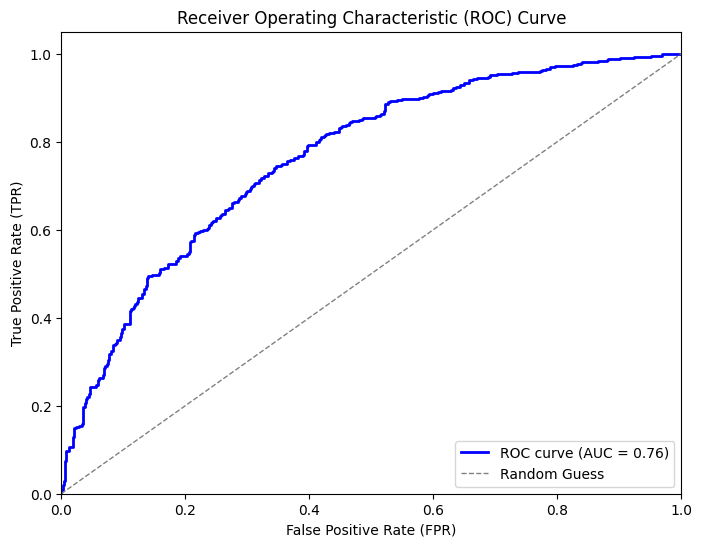

AUC: 0.76


In [34]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

#from sklearn.metrics import accuracy_score
#threshold = 0.5
#all_probs = (all_probs >= threshold).astype(int)
#accuracy = accuracy_score(all_labels, all_probs)
#print(accuracy)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Alternatively, calculate ROC AUC score directly
roc_auc_score_value = roc_auc_score(all_labels, all_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f"AUC: {roc_auc:.2f}")

The results show that the model is doing a decent job overall, with an accuracy of 65% and an AUC of 0.65, which is better than random guessing but still has room for improvement. It performs well at identifying instances of Epilepsy, correctly predicting 92% of them, but struggles with the Control class, only catching 28% of those cases. This suggests the model is better at recognizing Epilepsy but misses many Control instances, which could have been caused by data quality and lack of consistency in some samples. Model might have been improved with stricter rules for the quality of data, however there were not too many samples to begin with so we decided against it.

<!-- **Ways to possibly improve Model Performance?**

 1. Add More Node Features
Currently, you are using Katz FD and energy in 4 frequency bands (delta, theta, alpha, beta). You can include additional features like:
- **Signal Entropy:** A measure of the complexity of the EEG signal.
- **Inter-channel Correlation:** Measures the similarity between signals from different nodes.
- **Amplitude Variability:** Distribution of amplitude values over time.

---

 2. Experiment with Model Hyperparameters
Try modifying the following parameters:
- **Increase `hidden_channels`:** Add more hidden channels in the GAT model to capture complex patterns.
- **Increase the number of `heads` in GATConv:** More attention heads allow the model to learn richer relationships between nodes.

---

3. Regularization
To prevent overfitting, apply regularization techniques:
- **Dropout:** Add dropout layers to the GAT model to randomly drop some neurons during training.
- **L2 Regularization:** Penalize large weights in the model to enforce simplicity.

---

4. Balance Class Weights
If the dataset is imbalanced, use class weights to give more importance to underrepresented classes.

---

5. Increase the Number of Epochs
Train the model for more epochs to allow it to learn better patterns in the data. -->

### Interpretability

This process analyzes the importance of graph edges based on the attention weights learned by the GAT model. Attention weights indicate how much importance the model assigns to connections between nodes (edges) during message passing.

For each of the first 5 graphs in the test set:

1. Retrieve Attention Weights: Use the get_attention_weights function to extract the weights.
2. Convert to NumPy: Convert the weights to a NumPy array for visualization.
3. Plot Histogram: Display the distribution of attention weights using a histogram.

In [ ]:
def get_attention_weights(model, data):
    with torch.no_grad():
        # Perform forward pass and retrieve attention weights
        _, attention_weights = model.gat1(data.x, data.edge_index, return_attention_weights=True)
    return attention_weights

# Iterate through multiple graphs and visualize attention weights
for idx, data in enumerate(test_graphs[:5]):  # Analyze first 5 graphs
    attention_weights = get_attention_weights(model, data)

    # Convert attention weights to NumPy
    attention_weights = attention_weights[1].numpy()  # Use [1] to get the actual attention weights

    # Flatten the attention weights for histogram
    flattened_weights = attention_weights.flatten()

    # Plot histogram
    plt.hist(flattened_weights, bins=20, color='blue', alpha=0.7)
    plt.xlabel("Attention Weights")
    plt.ylabel("Frequency")
    plt.title(f"Attention Weights for Graph {idx + 1}")
    plt.show()

From the attention weights plot we see that the attention weights are predominantly weighting most edges as not important at all, some as very important, and much less values in between 0 and 1, which suggests the model is not effectively learning to differentiate between edges.

Now using Gat for node importance.

In [ ]:
# Example usage
data = test_graphs[0]  # Select one graph for analysis
batch = torch.zeros(data.x.size(0), dtype=torch.long)  # All nodes belong to the same graph

# Create Grad-CAM instance
grad_cam = GradCamGAT(model, target_layer=model.gat1)  # Use the first GAT layer as the target

# Forward pass through Grad-CAM
graph_output, node_output = grad_cam.forward(data.x, data.edge_index, data.edge_attr, batch)

# Backward pass to compute gradients
predicted_class = graph_output.argmax(dim=1).item()  # Get the predicted class
grad_cam.backward(graph_output, class_idx=predicted_class)

# Compute node importance
node_importance = grad_cam.get_node_importance()

# Visualize node importance
plt.bar(range(len(node_importance)), node_importance.numpy(), color='green')
plt.xlabel("Node Index")
plt.ylabel("Importance")
plt.title("Node Importance via Grad-CAM")
plt.show()

One of the nodes has a significantly higher importance than the others, one is deemed insignificant (<0). Concerning thing in above results is that the rest are uniform which signals that model is likely having underfitting issues.

# Guinea-Bissau Dataset

We'll do the same for Guinea-Bissau dataset.

Process all EEG files, create graphs and feature files.

In [ ]:
#process_all_files(gb_df, "output4/graphs_gb", "output4/features_gb")

n_epochs_per_sample = process_all_files_with_epochs(
    ni_df,
    "output4/graphs_gb_epoched",
    "output4/features_gb_epoched",
    duration=5,
    overlap=0
)

Similarly, let's load one sample graph

In [ ]:
import networkx as nx

# Path to a sample .gml file
gml_file = "output4/graphs_gb/GB-6_graph.gml"

# Load the graph from the .gml file
graph = nx.read_gml(gml_file)

# Print basic information about the graph
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

# Display a few edges with their weights
print("Sample edges with weights:")
for u, v, weight in graph.edges(data='weight'):
    print(f"({u}, {v}) -> weight: {weight}")

Visualizing the graph.

In [ ]:
# Load the graph
graph = nx.read_gml(gml_file)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Automatic layout for nodes
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=700,
    node_color="lightblue",
    font_size=10,
    font_color="black",
)
# Add edge labels showing weights
nx.draw_networkx_edge_labels(
    graph, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in graph.edges(data=True)}
)
plt.title("Visualization of EEG Graph (PLV)")
plt.show()


### GAT model

In [ ]:
# Directory containing .gml files
gml_dir = "output4/graphs_gb"
feature_dir = "output4/features_gb"

In [ ]:
# Load data
#graphs, labels = load_graphs_and_labels_with_features(gml_dir, feature_dir, gb_df)

# Load the epoched data with properly expanded labels
graphs, labels = load_graphs_and_labels_with_epochs(
    "output4/graphs_gb_epoched",
    "output4/features_gb_epoched",
    ni_df,
    n_epochs_per_sample
)

To ensure that both classes (Control and Epilepsy) are proportionally represented in the train and test datasets, we use a stratified split. This ensures the class balance is maintained in both subsets.

In [ ]:
# Stratified split to ensure both classes are represented in train and test sets
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    graphs, labels, test_size=0.2, stratify=labels, random_state=42
)


print("Train class distribution:", Counter(train_labels.numpy()))
print("Test class distribution:", Counter(test_labels.numpy()))


Setting up the DataLoader and Model Initialization

In [ ]:
# Create DataLoader
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)

# Initialize model
model = GATModel(in_channels=5, hidden_channels=8, out_channels=2)  # Binary classification
#optimizer = Adam(model.parameters(), lr=0.01)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
for epoch in range(50):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()

        # Forward pass
        node_output = model(data.x, data.edge_index, data.edge_attr)

        # Aggregate node outputs to graph-level predictions using batch information
        graph_output = global_mean_pool(node_output, data.batch)

        # Compute loss
        loss = F.nll_loss(graph_output, data.y)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss}")

In [ ]:
# Evaluate model on test set (with graph-level pooling)
model.eval()
all_preds = []
all_labels = []
all_probs = []

for data in test_graphs:
    # Forward pass
    node_output = model(data.x, data.edge_index, data.edge_attr)

    # Aggregate node outputs to graph-level predictions using batch information
    graph_prediction = global_mean_pool(node_output, data.batch)

    # Get predicted class
    preds = graph_prediction.argmax(dim=1)


    # Store predicted probabilities for the positive class (class 1)
    probs = torch.softmax(graph_prediction, dim=1)[:, 1].detach().numpy()  # Probabilities for class 1


    all_preds.append(preds.item())
    all_labels.append(data.y.item())

    all_probs.extend(probs)  # Append probabilities

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=['Control', 'Epilepsy']))


The model is struggling to correctly identify instances of the **Control** class, catching only 11% of them, while it performs much better with the **Epilepsy** class, correctly identifying 91% of those cases. Overall, the model's predictions are about 55% accurate, but the low recall for the Control class indicates it misses many of those instances. This suggests the model is biased toward the Epilepsy class and could benefit from more balanced dataset.

In [ ]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Alternatively, calculate ROC AUC score directly
roc_auc_score_value = roc_auc_score(all_labels, all_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f"AUC: {roc_auc:.2f}")

### Interpretability

In [ ]:
# Extract attention weights
def get_attention_weights(model, data):
    with torch.no_grad():
        # Perform forward pass and retrieve attention weights
        _, attention_weights = model.gat1(data.x, data.edge_index, return_attention_weights=True)
    return attention_weights

# Iterate through multiple graphs and visualize attention weights
for idx, data in enumerate(test_graphs[:7]):  # Analyze first 5 graphs
    attention_weights = get_attention_weights(model, data)

    # Convert attention weights to NumPy
    attention_weights = attention_weights[1].numpy()  # Use [1] to get the actual attention weights

    # Flatten the attention weights for histogram
    flattened_weights = attention_weights.flatten()

    # Plot histogram
    plt.hist(flattened_weights, bins=20, color='blue', alpha=0.7)
    plt.xlabel("Attention Weights")
    plt.ylabel("Frequency")
    plt.title(f"Attention Weights for Graph {idx + 1}")
    plt.show()

Again we mostly see that model considers majory of node unimportany, around 20 are very important, and only some are somewhere in-between. Once again we observe this diffculty with learning these patterns.

In [ ]:
# Example usage
data = test_graphs[0]  # Select one graph for analysis
batch = torch.zeros(data.x.size(0), dtype=torch.long)  # All nodes belong to the same graph

# Create Grad-CAM instance
grad_cam = GradCamGAT(model, target_layer=model.gat1)  # Use the first GAT layer as the target

# Forward pass through Grad-CAM
graph_output, node_output = grad_cam.forward(data.x, data.edge_index, data.edge_attr, batch)

# Backward pass to compute gradients
predicted_class = graph_output.argmax(dim=1).item()  # Get the predicted class
grad_cam.backward(graph_output, class_idx=predicted_class)

# Compute node importance
node_importance = grad_cam.get_node_importance()

# Visualize node importance
plt.bar(range(len(node_importance)), node_importance.numpy(), color='green')
plt.xlabel("Node Index")
plt.ylabel("Importance")
plt.title("Node Importance via Grad-CAM")
plt.show()

Higher importance scores indicate that the model considers those nodes more influential in making its predictions. We see that the importance scores are  uniform in some groups, it implies that the model isn't effectively distinguishing between important and less important nodes in certain groups of nodes.

# Final observations

From above results we see that there is room for improvement, starting from more restrictive data cleaning/selection as it presented some difficulties such as corrupted samples or inconsitencies in the size of samples etc. This comes with a risk as the dataset is not large and samples come from cheap EEG measuring devices. We also observe that ther could be a chance for improvement with for example better parameter choices for the models as we have seen some underfitting tendencies and difficulties with pattern recognition.

In [ ]:
#Alex Sandbox from here
#!pip install nilearn
'''
!pip install mne pyvista pyvistaqt qtpy
import mne
import numpy as np
import pyvista as pv

# Load FreeSurfer brain mesh
brain = mne.viz.Brain('fsaverage', subjects_dir='/path/to/freesurfer/subjects')

# Example EEG electrode positions in MNI space
coords = np.array([
    [-30, 40, 50], [30, 40, 50], [-50, 10, 40], [50, 10, 40],
    [-40, -20, 30], [40, -20, 30], [-10, -50, 20], [10, -50, 20]
])

# Create connectivity matrix
connectivity = np.random.rand(len(coords), len(coords))

# Create 3D PyVista plot
plotter = pv.Plotter()
plotter.add_mesh(brain._brain_mesh, color="white", opacity=0.3)

# Add EEG sensors as spheres
for coord in coords:
    plotter.add_mesh(pv.Sphere(radius=2, center=coord), color="red")

# Add connectivity edges
for i in range(len(coords)):
    for j in range(i+1, len(coords)):
        if connectivity[i, j] > 0.5:  # Thresholding
            plotter.add_mesh(pv.Line(coords[i], coords[j]), color="blue", line_width=2)

plotter.show()
'''